# LastFM Dissertation Highlights

This notebook is an exploration of the different music I listened to while I worked on my dissertation. I listened to music a lot while reading and writing, and I was wondering what my influences were.

## Keys

I put the [LastFM API](https://www.last.fm/api) key in my environment where I can import them.

In [1]:
import os
import dotenv

dotenv.load_dotenv()

LASTFM_KEY = os.environ['LASTFM_KEY']

## Get Recent Tracks

LastFM's API is kind of an older vintage of Web APIs called [XML-RPC](https://en.wikipedia.org/wiki/XML-RPC) which predated many of the REST APIs that have become more prevalent. While LastFM still does make XML available, it also uses JSON, which I suspect is used more often.

XMLRPC is different in that you invoke procedures by name by passing them as a parameter in a URL, along with other input paramters, and when you resolve that URL you get your result as XML (or in this case JSON). In some ways the more recent move to GraphQL is a throwback to XML-RPC where there is a single endpoint that takes a variety of queries.

Anyway LastFM's API has a method [user.getrecenttracks](https://www.last.fm/api/show/user.getRecentTracks) which can be used to fetch the tracks you listened to in a particular time. The most results you can get back for a particular time is 200. So here's a little Python function for retrieving the data. It takes a LastFM `user` name, and an optional `start` and `end` which are Python datetime objects.

In [2]:
import json
import requests

from datetime import datetime

def get_tracks(user, start=None, end=None):
    params = {
        "method": "user.getrecenttracks",
        "user": user,
        "api_key": LASTFM_KEY,
        "format": "json",
        "limit": 200,
    }
    
    if start:
        params['from'] = int(start.timestamp())
    if end:
        params['to'] = int(end.timestamp())
                
    response = requests.get('http://ws.audioscrobbler.com/2.0/', params=params)
    return response.json()['recenttracks']['track']

I've been a Now I can see what I listened to between January 1, 2015 and January 3, 2015.

In [3]:
start = datetime(2015, 1, 2)
end = datetime(2015, 1, 3)

result = get_tracks('inkdroid', start, end)
len(result)
print(json.dumps(result, indent=2))

[
  {
    "artist": {
      "mbid": "f2492c31-54a8-4347-a1fc-f81f72873bbf",
      "#text": "Mac DeMarco"
    },
    "album": {
      "mbid": "07216c6f-5932-49e6-846a-f3fd88b8d618",
      "#text": "Salad Days"
    },
    "image": [
      {
        "size": "small",
        "#text": "https://lastfm.freetls.fastly.net/i/u/34s/28ffd87a1e554022c0065398979894c4.png"
      },
      {
        "size": "medium",
        "#text": "https://lastfm.freetls.fastly.net/i/u/64s/28ffd87a1e554022c0065398979894c4.png"
      },
      {
        "size": "large",
        "#text": "https://lastfm.freetls.fastly.net/i/u/174s/28ffd87a1e554022c0065398979894c4.png"
      },
      {
        "size": "extralarge",
        "#text": "https://lastfm.freetls.fastly.net/i/u/300x300/28ffd87a1e554022c0065398979894c4.png"
      }
    ],
    "streamable": "0",
    "date": {
      "uts": "1420245227",
      "#text": "03 Jan 2015, 00:33"
    },
    "url": "https://www.last.fm/music/Mac+DeMarco/_/Passing+Out+Pieces",
    "name": 

## Pandas

I thought it would be nice to be able to have these as a Pandas dataframe to make it easier to look for patterns.

In [8]:
import pandas

def get_tracks_df(user, start, end):
    results = []
    for track in get_tracks(user, start, end):
        results.append([
            datetime.utcfromtimestamp(int(track['date']['uts'])),
            track['mbid'],
            track['name'],
            track['artist']['#text'],
            track['album']['#text'],
            track['image'][-1]['#text']
        ])
    return pandas.DataFrame(results, columns=[
        'timestamp',
        'track_id',
        'track_name',
        'artist',
        'album',
        'image'
    ])    

In [9]:
df = get_tracks_df('inkdroid', start, end)
df


,timestamp,track_id,track_name,artist,album,image
0,2015-01-03 00:33:47,5c7fa676-9a29-44b3-9c66-bbcf3c8c2cd7,Passing Out Pieces,Mac DeMarco,Salad Days,https://lastfm.freetls.fastly.net/i/u/300x300/...
1,2015-01-03 00:19:26,07bc1d97-a837-413d-9f39-5d9827057cb7,Let My Baby Stay,Mac DeMarco,Salad Days,https://lastfm.freetls.fastly.net/i/u/300x300/...
2,2015-01-03 00:16:27,41647f37-bd6e-43ad-a2d6-d8c70330b1dc,Goodbye Weekend,Mac DeMarco,Salad Days,https://lastfm.freetls.fastly.net/i/u/300x300/...
3,2015-01-03 00:13:25,13a73146-ee26-4bec-9067-f8f8001578ae,Let Her Go,Mac DeMarco,Salad Days,https://lastfm.freetls.fastly.net/i/u/300x300/...


Or look at a longer time period, e.g. 2015-01-01 to 2015-02-01

In [10]:
df = get_tracks_df('inkdroid', datetime(2015, 1, 1), datetime(2015, 2, 1))


But remember that we can only get up to 200 tracks at a time. I requested tracks for 2015-01-01 to 2015-01-15 but look at the minimum and maximum datetimes for these track plays:

In [11]:
df['timestamp'].max()

Timestamp('2015-02-01 00:56:00')

In [12]:
df['timestamp'].min()

Timestamp('2015-01-23 17:23:22')

Which is kind of interesting because it seems to work backwards from the most recent play.

## Larger Time Windows

To be able to look at larger time windows we would need to be able to notice when there appears to be activity missing from the response and adjust the query to ask for it. Since it appears that results are truncated from the beginning of the range we can update get_tracks to notice when the results don't go back to the supplied start datetime. If they don't then it recursively calls itself using the 

In [13]:
def get_tracks(user, start=None, end=None):
    params = {
        "method": "user.getrecenttracks",
        "user": user,
        "api_key": LASTFM_KEY,
        "format": "json",
        "limit": 200,
    }
    
    if start:
        params['from'] = int(start.timestamp())
    if end:
        params['to'] = int(end.timestamp())
                
    response = requests.get('http://ws.audioscrobbler.com/2.0/', params=params)
    
    earliest = None
    for track in response.json()['recenttracks']['track']:
        t = datetime.utcfromtimestamp(int(track['date']['uts']))
        if start and t < start:
            break
        if earliest is None or t < earliest:
            earliest = t
        yield track
        
    if start and earliest and earliest != end:
        print('getting tracks for', user, start, earliest)
        yield from get_tracks(user, start, earliest)
    
    

In [14]:
df = get_tracks_df('inkdroid', datetime(2015, 1, 1), datetime(2015, 2, 1))


getting tracks for inkdroid 2015-01-01 00:00:00 2015-01-23 17:23:22
getting tracks for inkdroid 2015-01-01 00:00:00 2015-01-16 16:27:42
getting tracks for inkdroid 2015-01-01 00:00:00 2015-01-06 22:11:29
getting tracks for inkdroid 2015-01-01 00:00:00 2015-01-03 00:13:25


In [15]:
df['timestamp'].min()

Timestamp('2015-01-03 00:13:25')

In [16]:
df['timestamp'].max()

Timestamp('2015-02-01 00:56:00')

## Popular Album?

What were the albums I listened to the most in that month? Pandas makes that easy.

In [17]:
df['album'].value_counts()

The Mysterious Production of Eggs                          67
The Essential Tito Puente                                  50
Cellar Door                                                25
bitter sweet                                               22
Holkham Drones                                             21
                                                           ..
Digs Other People's Songs                                   1
Do You Know Squarepusher                                    1
Aw Come Aw Wry                                              1
The Breakfast Club (Original Motion Picture Soundtrack)     1
Range Anxiety                                               1
Name: album, Length: 123, dtype: int64

Who are the artists?

In [18]:
df.groupby(['artist', 'album']).count().sort_values('timestamp', ascending=False)

,,timestamp,track_id,track_name,image
artist,album,,,,
Andrew Bird,The Mysterious Production of Eggs,67,67,67,67
Tito Puente,The Essential Tito Puente,50,50,50,50
John Vanderslice,Cellar Door,25,25,25,25
Sawako,bitter sweet,22,22,22,22
Luke Abbott,Holkham Drones,21,21,21,21
...,...,...,...,...,...
Sam Smith,In The Lonely Hour (Deluxe),1,1,1,1
Arcade Fire,The Suburbs Deluxe,1,1,1,1
Shawn Mendes,Something Big,1,1,1,1


## Top Albums by Week?

What about the top albums for each week of January 2015.

In [19]:
weeks = df.groupby([df.timestamp.dt.isocalendar().week, 'artist', 'album']).agg('count').sort_values(['week', 'timestamp'], ascending=[True, False])

pandas.set_option('display.max_rows', 250)
weeks

timestamp  \
week artist                         album                                                           
1    Moby                           Wait for Me                                                14   
     Wye Oak                        Shriek                                                     10   
     Jenny Lewis                    The Voyager                                                 9   
     Mac DeMarco                    Salad Days                                                  8   
     Talking Heads                  Remain In Light (Deluxe Version)                            8   
     The National                   Boxer                                                       5   
                                    Trouble Will Find Me                                        5   
     The Walkmen                    Bows + Arrows                                               2   
     Arcade Fire                    Funeral                                                     1   
                                    Neon Bible                                                  1   
                                    Reflektor                                                   1   
                                    The Suburbs                                                 1   
                                    The Suburbs Deluxe                                          1   
     John Vanderslice               Cellar Door                                                 1   
     Megafaun                       Megafaun                                                    1   
     Nicole Atkins                  Digs Other People's Songs                                   1   
                                    Neptune City                                                1   
                                    Party's Over                                                1   
     Phosphorescent                 Aw Come Aw Wry                                              1   
                                    To Willie                                                   1   
     The National                   High Violet                                                 1   
     The Twilight Singers           twilight as played by the twilight singers                  1   
     The Walkmen                    Everyone Who Pretended to Like Me Is Gone                   1   
                                    Lisbon                                                      1   
                                    Pussy Cats Starring The Walkmen                             1   
     Wye Oak                        Civilian                                                    1   
                                    If Children                                                 1   
2    John Wizards                   John Wizards                                               15   
     Kuedo                          Severant                                                   15   
     Ital Tek                       Control                                                    13   
     Nils Frahm                     The Bells                                                  11   
     The Ruby Suns                  Christopher                                                10   
     David Bowie                    Low                                                         7   
     Matmos                         A Chance to Cut Is a Chance to Cure                         7   
     Dj Rupture                     Uproot                                                      4   
     David Bowie                    Scary Monsters                                              3   
     Machinedrum                    Room(s) Extended                                            3   
     Raspberry Bulbs                Privacy                                                     3   
     Clark                          Clark       

So I can see from that table that in week 3 of January 2015 I went crazy listening to Andrew Bird's The Mysterious Production of Eggs.

## Dissertating

So I started this wanting to get a sense of the albums I listened to the most as I worked through my PhD program.  I [started](https://inkdroid.org/2015/08/29/ischool/) my PhD August 29, 2015 and finished November 6, 2020. Hopefully I have enough memory :)

In [20]:
df = get_tracks_df('inkdroid', datetime(2015, 8, 29), datetime(2020, 11, 6))

getting tracks for inkdroid 2015-08-29 00:00:00 2020-09-30 22:51:12
getting tracks for inkdroid 2015-08-29 00:00:00 2020-09-07 21:16:51
getting tracks for inkdroid 2015-08-29 00:00:00 2020-08-16 22:44:28
getting tracks for inkdroid 2015-08-29 00:00:00 2020-08-01 21:59:56
getting tracks for inkdroid 2015-08-29 00:00:00 2020-07-14 23:10:44
getting tracks for inkdroid 2015-08-29 00:00:00 2020-06-28 23:02:53
getting tracks for inkdroid 2015-08-29 00:00:00 2020-06-21 00:09:48
getting tracks for inkdroid 2015-08-29 00:00:00 2020-06-08 13:47:21
getting tracks for inkdroid 2015-08-29 00:00:00 2020-05-29 15:20:53
getting tracks for inkdroid 2015-08-29 00:00:00 2020-05-16 00:52:49
getting tracks for inkdroid 2015-08-29 00:00:00 2020-05-06 01:06:41
getting tracks for inkdroid 2015-08-29 00:00:00 2020-04-26 00:59:33
getting tracks for inkdroid 2015-08-29 00:00:00 2020-04-17 23:11:08
getting tracks for inkdroid 2015-08-29 00:00:00 2020-04-08 01:15:56
getting tracks for inkdroid 2015-08-29 00:00:00 

getting tracks for inkdroid 2015-08-29 00:00:00 2017-03-25 18:32:07
getting tracks for inkdroid 2015-08-29 00:00:00 2017-03-16 19:02:03
getting tracks for inkdroid 2015-08-29 00:00:00 2017-03-10 23:34:44
getting tracks for inkdroid 2015-08-29 00:00:00 2017-03-07 18:04:46
getting tracks for inkdroid 2015-08-29 00:00:00 2017-03-01 23:15:38
getting tracks for inkdroid 2015-08-29 00:00:00 2017-02-25 04:19:20
getting tracks for inkdroid 2015-08-29 00:00:00 2017-02-16 23:42:58
getting tracks for inkdroid 2015-08-29 00:00:00 2017-02-08 17:56:54
getting tracks for inkdroid 2015-08-29 00:00:00 2017-01-23 00:08:14
getting tracks for inkdroid 2015-08-29 00:00:00 2017-01-15 11:45:17
getting tracks for inkdroid 2015-08-29 00:00:00 2016-12-31 17:55:53
getting tracks for inkdroid 2015-08-29 00:00:00 2016-12-20 14:16:02
getting tracks for inkdroid 2015-08-29 00:00:00 2016-12-15 02:31:25
getting tracks for inkdroid 2015-08-29 00:00:00 2016-12-08 15:05:23
getting tracks for inkdroid 2015-08-29 00:00:00 

Oh my god. It worked!

In [21]:
len(df)

36470

Gonna save that off in case we come back to this notebook.

In [26]:
df.to_csv('data/diss-music.csv', index=False)

### Group by Month

36,470 songs played. So maybe group by month first? It's actually a bit easier if we just create a new column for the year-month.

In [28]:
df['year_month'] = df.timestamp.dt.to_period('M')

months = df.groupby(['year_month', 'artist', 'album', 'image'])
months = months.agg(count=('timestamp', 'count')).sort_values(['year_month', 'count'], ascending=[False, False])
months

count
year_month artist                 album                                       image                                                    
2020-11    R.E.M.                 Murmur - Deluxe Edition                     https://lastfm.freetls.fastly.net/i/u/300x300/f...     18
           Glacis & Gavin Miller  Nothing Hurts Forever                       https://lastfm.freetls.fastly.net/i/u/300x300/2...     17
           Tom Petty              Full Moon Fever                             https://lastfm.freetls.fastly.net/i/u/300x300/f...      5
           Bright Eyes            Down In The Weeds, Where The World Once Was https://lastfm.freetls.fastly.net/i/u/300x300/7...      4
           Tropic of Coldness     Human Kindness                              https://lastfm.freetls.fastly.net/i/u/300x300/f...      4
...                                                                                                                                 ...
2015-09    Wonk Unit                                                                                                                  1
           Yellow Magic Orchestra                                                                                                     1
2015-08    White Rainbow          Thru.u                                      https://lastfm.freetls.fastly.net/i/u/300x300/f...      9
           Yo La Tengo            Ride the Tiger                              https://lastfm.freetls.fastly.net/i/u/300x300/e...      6
           Will Sessions          The Elmatic Instrumentals                   https://lastfm.freetls.fastly.net/i/u/300x300/e...      1

[7856 rows x 1 columns]

It would be nice to get the top 5 for each month and discard the rest.

In [29]:
months_top_5 = (months.sort_values(['year_month', 'count'], ascending=[True, False])
   .groupby(level=0, as_index=False)
   .apply(lambda x: x.head(5) if len(x) >= 5 else x.head(0))
   .reset_index(level=0, drop=True)
)
months_top_5

count
year_month artist                album                                       image                                                    
2015-09    Deradoorian           The Expanding Flower Planet                 https://lastfm.freetls.fastly.net/i/u/300x300/a...     42
           Bat for Lashes        The Haunted Man (Deluxe Version)            https://lastfm.freetls.fastly.net/i/u/300x300/7...     40
           CHVRCHES              Every Open Eye                              https://lastfm.freetls.fastly.net/i/u/300x300/2...     37
           Beach House           Depression Cherry                           https://lastfm.freetls.fastly.net/i/u/300x300/9...     36
           Crystal Castles       Crystal Castles                             https://lastfm.freetls.fastly.net/i/u/300x300/6...     32
...                                                                                                                                ...
2020-11    R.E.M.                Murmur - Deluxe Edition                     https://lastfm.freetls.fastly.net/i/u/300x300/f...     18
           Glacis & Gavin Miller Nothing Hurts Forever                       https://lastfm.freetls.fastly.net/i/u/300x300/2...     17
           Tom Petty             Full Moon Fever                             https://lastfm.freetls.fastly.net/i/u/300x300/f...      5
           Bright Eyes           Down In The Weeds, Where The World Once Was https://lastfm.freetls.fastly.net/i/u/300x300/7...      4
           Tropic of Coldness    Human Kindness                              https://lastfm.freetls.fastly.net/i/u/300x300/f...      4

[315 rows x 1 columns]

In [33]:
for year_month, new_df in months_top_5.groupby(level=0):
    print()
    print(year_month)
    for index, row in new_df.iterrows():
        print(index[1], '-', index[2])


2015-09
Deradoorian - The Expanding Flower Planet
Bat for Lashes - The Haunted Man (Deluxe Version)
CHVRCHES - Every Open Eye
Beach House - Depression Cherry
Crystal Castles - Crystal Castles

2015-10
James Elkington and Nathan Salsburg - Ambsace
Grizzly Bear - Horn Of Plenty
yuk. - a n a k
Darkstar - Foam Island
James Blake - James Blake

2015-11
Moderat - II
Darkstar - Foam Island
CHVRCHES - Every Open Eye
Oval - Voa
David Bowie - Best of Bowie

2015-12
Deerhunter - Fading Frontier
Lau Nau - Hem. Någonstans
Helen - The Original Faces
Lanterns on the Lake - Beings
Ghostpoet - Shedding Skin

2016-01
David Bowie - Blackstar
Jonathan Kawchuk - North
David Bowie - Heroes
Lau Nau - Hem. Någonstans
Bon Iver - Bon Iver (Deluxe Edition)

2016-02
Library Tapes - Escapism
Slow Meadow - Slow Meadow
David Bowie - Nothing Has Changed (Deluxe Edition)
Luke Abbott - Holkham Drones
The Declining Winter - Home For Lost Souls

2016-03
Twincities - ...plays the brown mountain lights
Radiohead - OK Comp

That's interesting but it's a lot of informatoin. How about the top album per month?


In [64]:
months_top = (months.sort_values(['year_month', 'count'], ascending=[True, False])
   .groupby(level=0, as_index=False)
   .apply(lambda x: x.head(1) if len(x) >= 1 else x.head(0))
   .reset_index(level=0, drop=True)
)
months_top = months_top.reset_index()
months_top

,year_month,artist,album,image,count
0,2015-08,White Rainbow,Thru.u,https://lastfm.freetls.fastly.net/i/u/300x300/...,9
1,2015-09,Deradoorian,The Expanding Flower Planet,https://lastfm.freetls.fastly.net/i/u/300x300/...,42
2,2015-10,James Elkington and Nathan Salsburg,Ambsace,https://lastfm.freetls.fastly.net/i/u/300x300/...,43
3,2015-11,Moderat,II,https://lastfm.freetls.fastly.net/i/u/300x300/...,34
4,2015-12,Deerhunter,Fading Frontier,https://lastfm.freetls.fastly.net/i/u/300x300/...,86
5,2016-01,David Bowie,Blackstar,https://lastfm.freetls.fastly.net/i/u/300x300/...,38
6,2016-02,Library Tapes,Escapism,https://lastfm.freetls.fastly.net/i/u/300x300/...,52
7,2016-03,Twincities,...plays the brown mountain lights,https://lastfm.freetls.fastly.net/i/u/300x300/...,37
8,2016-04,Moderat,III,https://lastfm.freetls.fastly.net/i/u/300x300/...,93
9,2016-05,Radiohead,A Moon Shaped Pool,https://lastfm.freetls.fastly.net/i/u/300x300/...,106


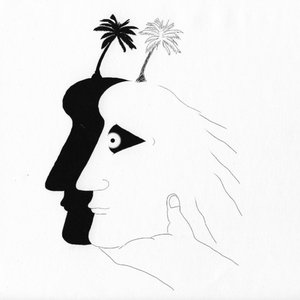

2015-08 - White Rainbow / Thru.u


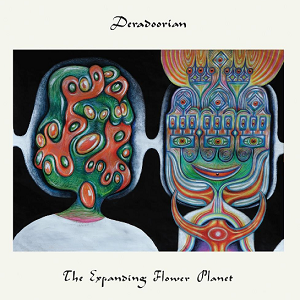

2015-09 - Deradoorian / The Expanding Flower Planet


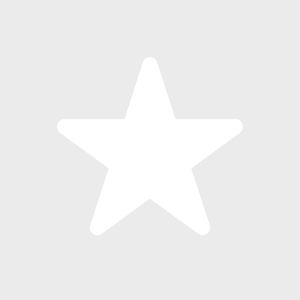

2015-10 - James Elkington and Nathan Salsburg / Ambsace


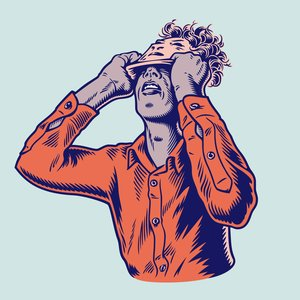

2015-11 - Moderat / II


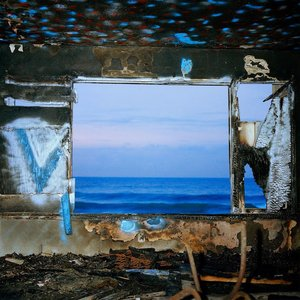

2015-12 - Deerhunter / Fading Frontier


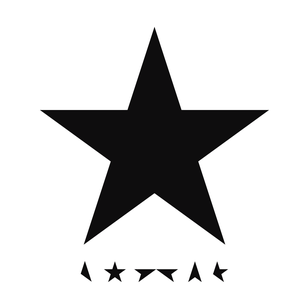

2016-01 - David Bowie / Blackstar


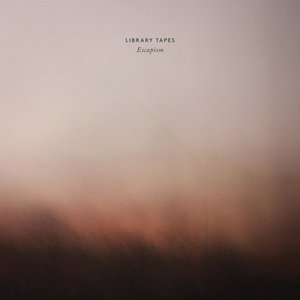

2016-02 - Library Tapes / Escapism


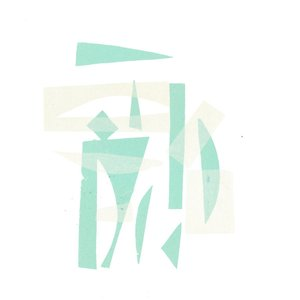

2016-03 - Twincities / ...plays the brown mountain lights


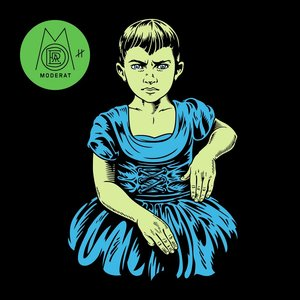

2016-04 - Moderat / III


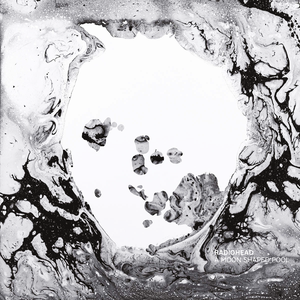

2016-05 - Radiohead / A Moon Shaped Pool


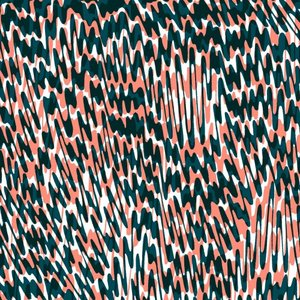

2016-06 - Tigue / Peaks


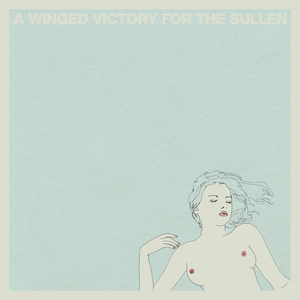

2016-07 - A Winged Victory for the Sullen / A Winged Victory for the Sullen


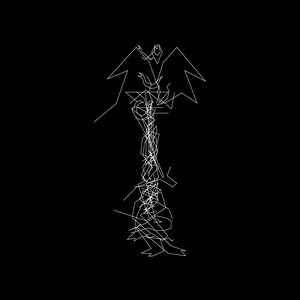

2016-08 - Oneohtrix Point Never / Garden of Delete


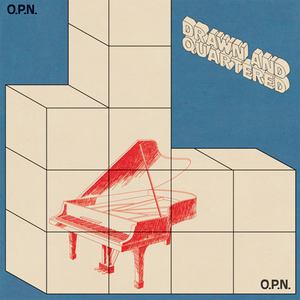

2016-09 - Oneohtrix Point Never / Drawn and Quartered


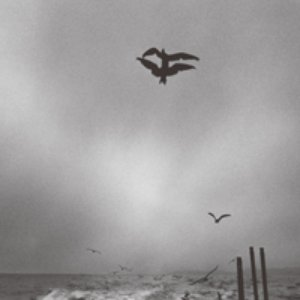

2016-10 - Chihei Hatakeyama / Saunter


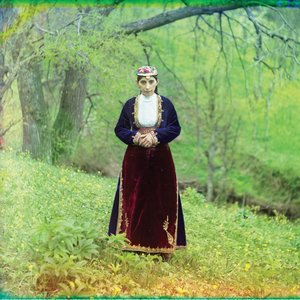

2016-11 - Biosphere / Departed Glories


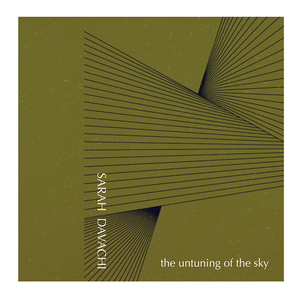

2016-12 - Sarah Davachi / The Untuning of the Sky


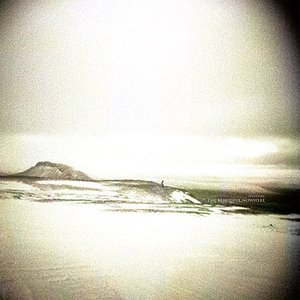

2017-01 - OFFTHESKY / The Beautiful Nowhere


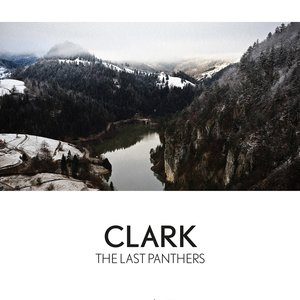

2017-02 - Clark / The Last Panthers


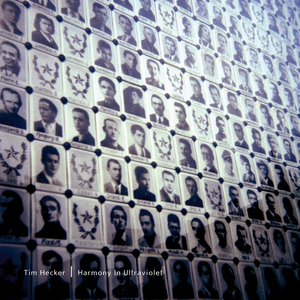

2017-03 - Tim Hecker / Harmony In Ultraviolet


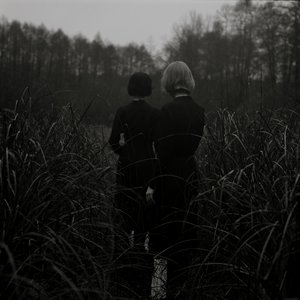

2017-04 - Goldmund / Sometimes


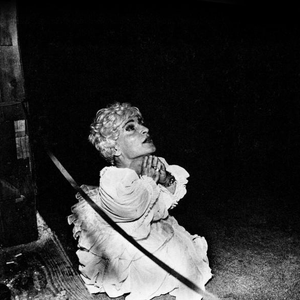

2017-05 - Deerhunter / Halcyon Digest


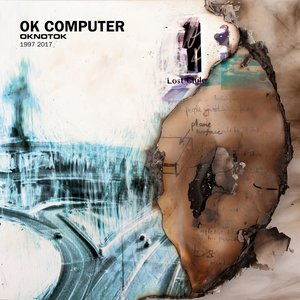

2017-06 - Radiohead / OK Computer OKNOTOK 1997 2017


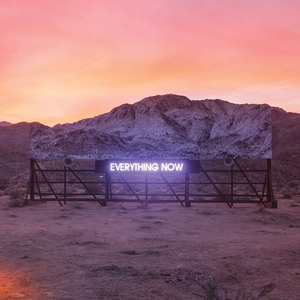

2017-07 - Arcade Fire / Everything Now


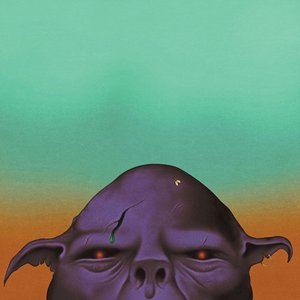

2017-08 - oh sees / Orc


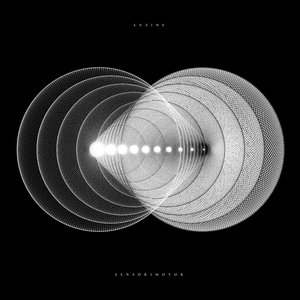

2017-09 - Lusine / Sensorimotor


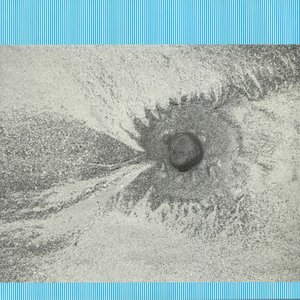

2017-10 - Four Tet / New Energy


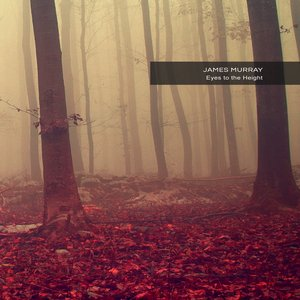

2017-11 - James Murray / Eyes to the Height


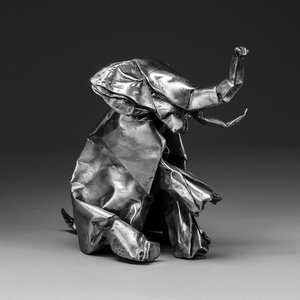

2017-12 - Jlin / Black Origami


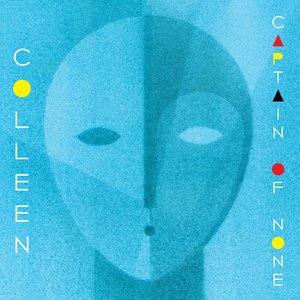

2018-01 - Colleen / Captain of None (Bonus Track Version)


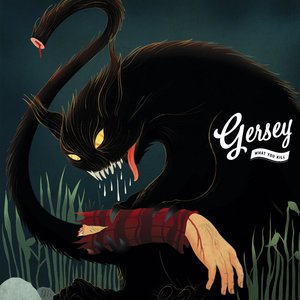

2018-02 - Gersey / What You Kill


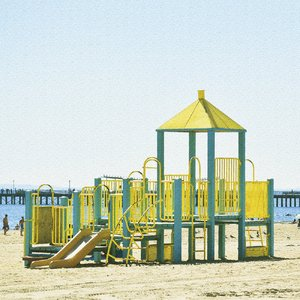

2018-03 - Rhucle / Yellow Beach


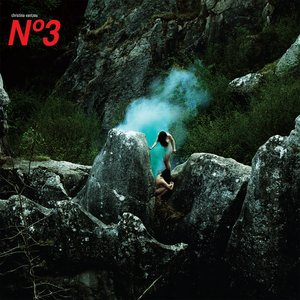

2018-04 - Christina Vantzou / No. 3


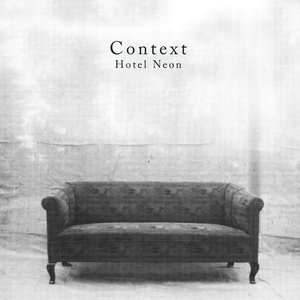

2018-05 - Hotel Neon / Context


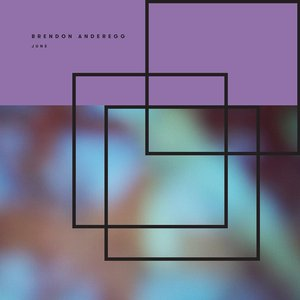

2018-06 - Brendon Anderegg / June


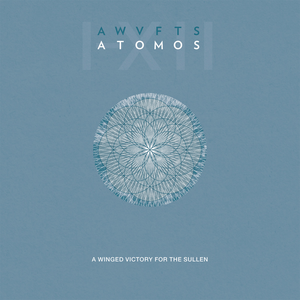

2018-07 - A Winged Victory for the Sullen / Atomos


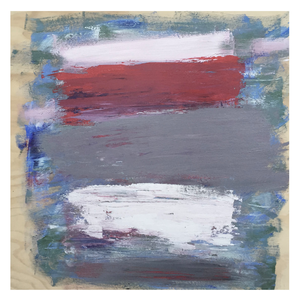

2018-08 - Ezekiel Honig / A Passage of Concrete


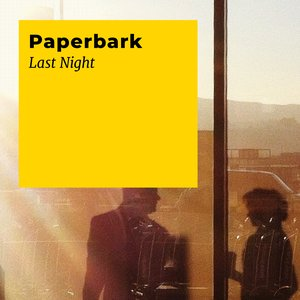

2018-09 - Paperbark / Last Night


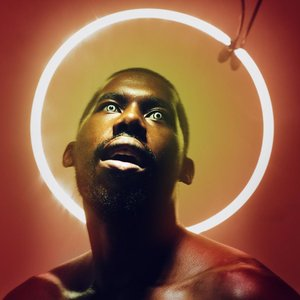

2018-10 - Flying Lotus / You're Dead! (Deluxe Edition)


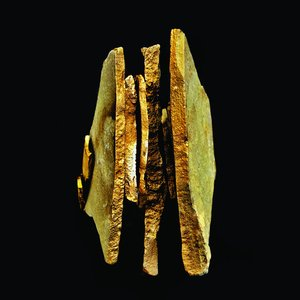

2018-11 - Porya Hatami / Kaziwa


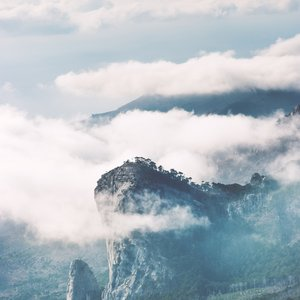

2018-12 - Sven Laux / You'll Be Fine.


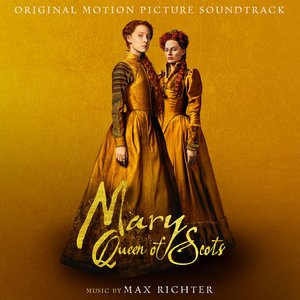

2019-01 - Max Richter / Mary Queen Of Scots (Original Motion Picture Soundtrack)


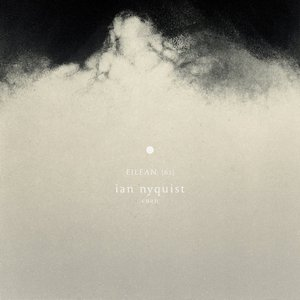

2019-02 - Ian Nyquist / Cuan


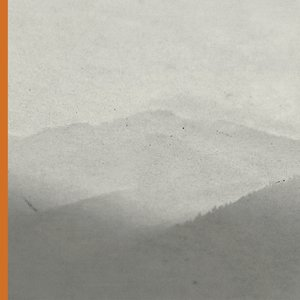

2019-03 - Jens Pauly / Vihne


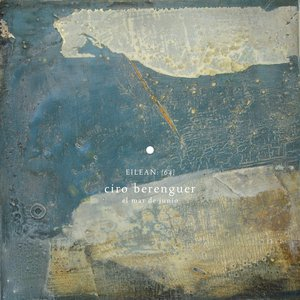

2019-04 - Ciro Berenguer / El Mar De Junio


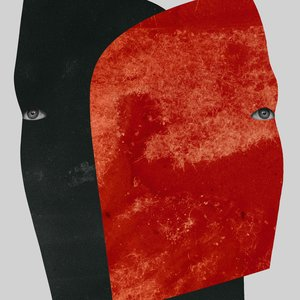

2019-05 - Rival Consoles / Persona


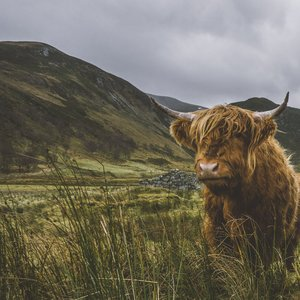

2019-06 - Caught In The Wake Forever / Waypoints


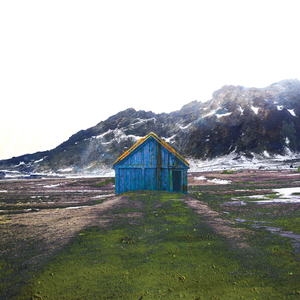

2019-07 - Spheruleus / Light Through Open Blinds


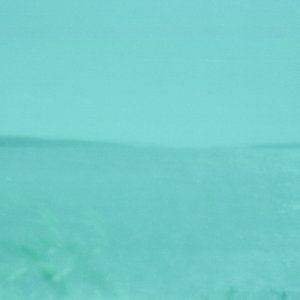

2019-08 - Valotihkuu / By The River


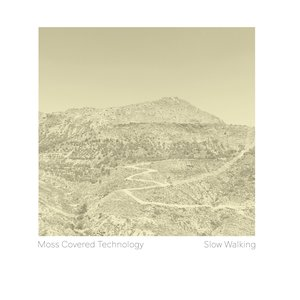

2019-09 - Moss Covered Technology / Slow Walking


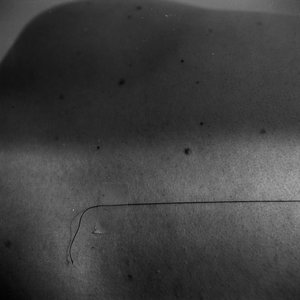

2019-10 - Tsone / pagan oceans I, II, III


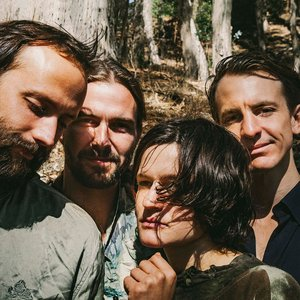

2019-11 - Big Thief / Two Hands


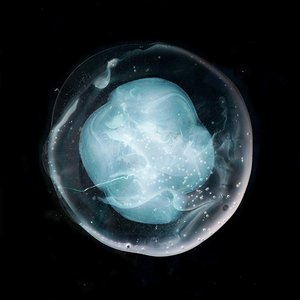

2019-12 - A Winged Victory for the Sullen / The Undivided Five


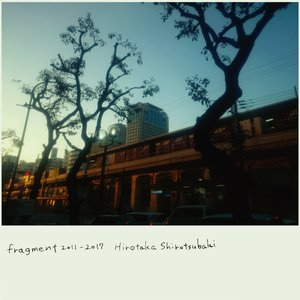

2020-01 - Hirotaka Shirotsubaki / fragment 2011-2017


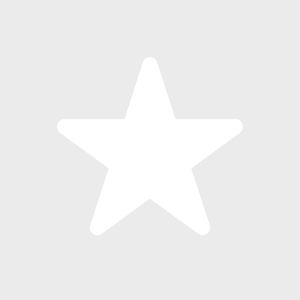

2020-02 - Luis Miehlich / Timecuts


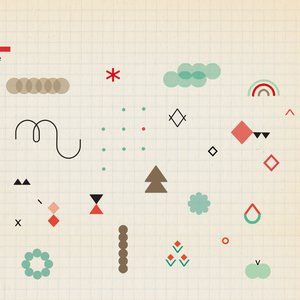

2020-03 - Federico Durand / Jardín de invierno


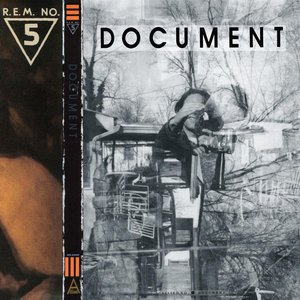

2020-04 - R.E.M. / Document - 25th Anniversary Edition


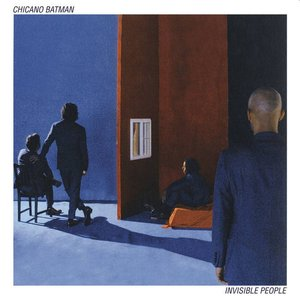

2020-05 - Chicano Batman / Invisible People


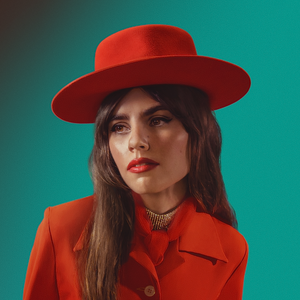

2020-06 - Hazel English / Wake Up!


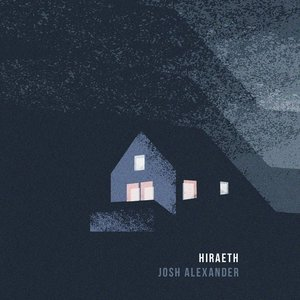

2020-07 - Josh Alexander / Hiraeth


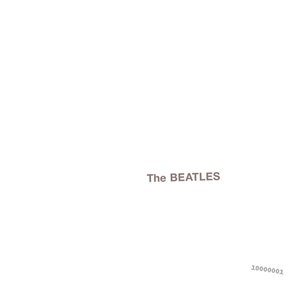

2020-08 - The Beatles / The Beatles (Remastered)


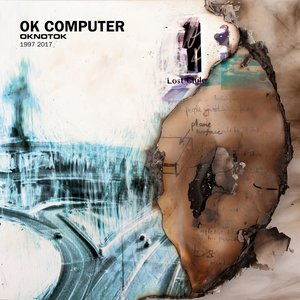

2020-09 - Radiohead / OK Computer OKNOTOK 1997 2017


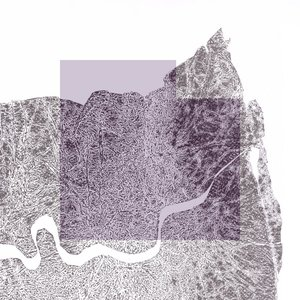

2020-10 - Mathieu Karsenti / Bygones


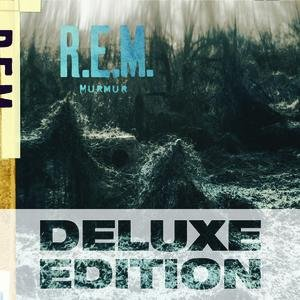

2020-11 - R.E.M. / Murmur - Deluxe Edition


In [90]:
from IPython.display import display, Image

for i, row in months_top.iterrows():
    display(Image(row['image']))
    print('{0[year_month]} - {0[artist]} / {0[album]}'.format(row))
    

It would be nice to output some HTML that I could copy/paste into a blog post.

In [80]:
from urllib.parse import quote

for i, row in months_top.iterrows():
    
    album = {
        'artist': row['artist'],
        'artist_url': 'https://www.last.fm/music/' + quote(row['artist']),
        'album': row['album'],
        'album_url': 'https://www.last.fm/music/' + quote(row['artist']) + '/' + quote(row['album']),
        'image': row['image'], 
        'month': row['year_month'],
        'count': row['count']
    }
        
    print("""
<div class="album">
  {0[month]} <br>
  <a href="{0[album_url]}"><img title="{0[count]} plays" src="{0[image]}"></a>
  <a href="{0[artist_url]}">{0[artist]}</a> / 
  <a href="{0[album_url]}">{0[album]}</a>
</div>
    """.format(album))




<div class="album">
  2015-08 <br>
  <a href="https://www.last.fm/music/White%20Rainbow/Thru.u"><img title="9 plays" src="https://lastfm.freetls.fastly.net/i/u/300x300/f6bb2145b3bc42e1c2b74901588128d0.jpg"></a>
  <a href="https://www.last.fm/music/White%20Rainbow">White Rainbow</a> / 
  <a href="https://www.last.fm/music/White%20Rainbow/Thru.u">Thru.u</a>
</div>
    

<div class="album">
  2015-09 <br>
  <a href="https://www.last.fm/music/Deradoorian/The%20Expanding%20Flower%20Planet"><img title="42 plays" src="https://lastfm.freetls.fastly.net/i/u/300x300/a70a7c51328c38ad9d3fba9d3838fdd6.png"></a>
  <a href="https://www.last.fm/music/Deradoorian">Deradoorian</a> / 
  <a href="https://www.last.fm/music/Deradoorian/The%20Expanding%20Flower%20Planet">The Expanding Flower Planet</a>
</div>
    

<div class="album">
  2015-10 <br>
  <a href="https://www.last.fm/music/James%20Elkington%20and%20Nathan%20Salsburg/Ambsace"><img title="43 plays" src="https://lastfm.freetls.fastly.net/i/u/300x3